# Reception Quality and Gap Length Evaluation

This notebook contains code for evaluating satellite reception quality and the sensitivity to certain methodological choices, such as restricting included vessel classes and limiting vessel speed. It also includes analysis of AIS gap length.

Figures and analyses are to be included in the paper's Supplementary Information.

In [18]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib import colors,colorbar, cm

import pyseas
import pyseas.maps
import pyseas.maps.rasters
import pyseas.styles
import pyseas.cm
import cmocean

# Direct notebook to see local modules for import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_production import utils

%load_ext autoreload
%autoreload 2
%load_ext google.cloud.bigquery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
# Parameters
destination_dataset = 'proj_ais_gaps_catena'
output_version = 'v20210722'
start_date = pd.date_range('2017-01-01', '2017-01-01', freq='1D')[0]

# Reception quality tables
sat_reception_smoothed_tbl = 'sat_reception_smoothed_one_degree_{}'.format(output_version)
sat_reception_measured_tbl = 'sat_reception_measured_one_degree_{}'.format(output_version)

## Reception quality
### Measured reception

Query data.

In [17]:
"""
Query measured reception data
"""
sat_reception_measured_query = '''SELECT 
                                   lat_bin,
                                   lon_bin,
                                   cls as class,
                                   AVG(sat_pos_per_day) as positions_per_day
                                   FROM `{d}.{t}`
                                   WHERE _partitiontime BETWEEN "2017-01-01" 
                                   AND "2019-12-01"
                                   GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                            t = sat_reception_measured_tbl)
# Query data
sat_reception_measured = pd.read_gbq(sat_reception_measured_query, project_id='world-fishing-827', dialect='standard')

Plot measured reception.

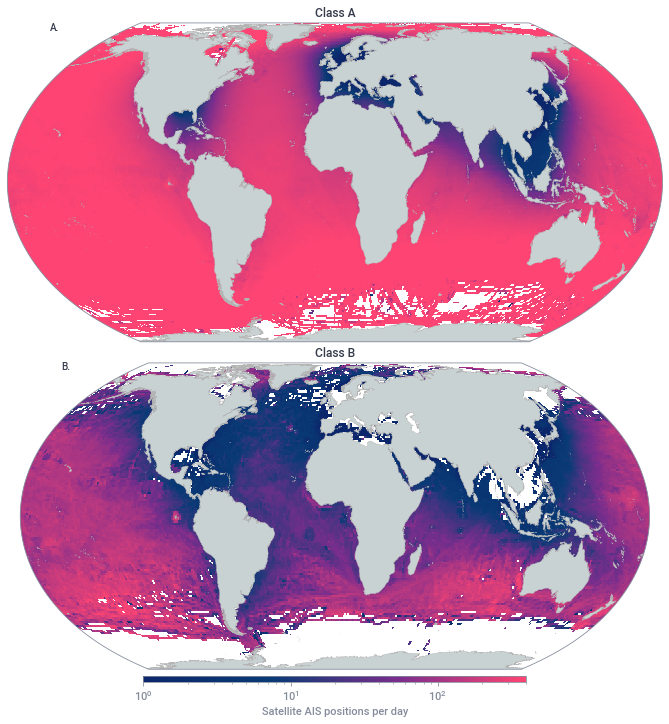

In [28]:
# Drop NAs
sat_reception_measured = sat_reception_measured.dropna(subset=['lat_bin','lon_bin'])

# Class A
class_a_reception = pyseas.maps.rasters.df2raster(sat_reception_measured[sat_reception_measured['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','positions_per_day',
                                                  xyscale=1, 
                                                  per_km2=False)

# Class B
class_b_reception = pyseas.maps.rasters.df2raster(sat_reception_measured[sat_reception_measured['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','positions_per_day',
                                                  xyscale=1, 
                                                  per_km2=False)

fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light):
    
    axes = []
    ims = []
    fig_min_value = 1
    fig_max_value = 400  
    
    # Class A
    grid = class_a_reception
    grid[grid<fig_min_value/fig_max_value]=np.nan
    norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = 'reception',
                                     norm = norm)
    
    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")
    
    # Class B
    grid = class_b_reception
    grid[grid<fig_min_value/fig_max_value]=np.nan
    norm = colors.LogNorm(vmin=fig_min_value, vmax=fig_max_value)
    
    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap='reception',
                                     norm = norm)
    
    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")
    
    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )
    
    cbar.set_label("Satellite AIS positions per day")
    
plt.tight_layout(pad=0.5)
plt.savefig("../results/gap_figures_{}/figure_si_measured_reception.png".format(output_version),dpi=200, bbox_inches='tight') 

### Smooth reception

In [85]:
"""
Query smoothed reception data
"""
sat_reception_smooth_query = '''SELECT 
                                   lat_bin,
                                   lon_bin,
                                   class,
                                   AVG(positions_per_day) as positions_per_day
                                   FROM `{d}.{t}`
                                   WHERE _partitiontime BETWEEN "2017-01-01" 
                                   AND "2019-12-01"
                                   GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                            t = sat_reception_smoothed_tbl)
# Query data
sat_reception_smooth = pd.read_gbq(sat_reception_smooth_query, project_id='world-fishing-827', dialect='standard')

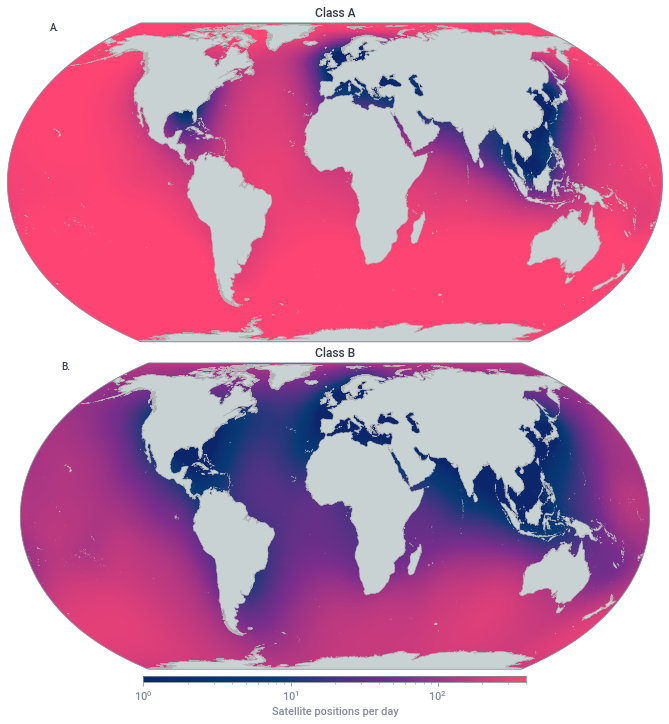

In [30]:
# Plot reception quality with same color scales
utils.plot_reception_quality(reception_start_date = start_date,
                             reception_df = sat_reception_smooth
                        )

# Save figure
plt.savefig("../results/gap_figures_{}/figure_si_smooth_reception.png".format(output_version),dpi=200, bbox_inches='tight') 

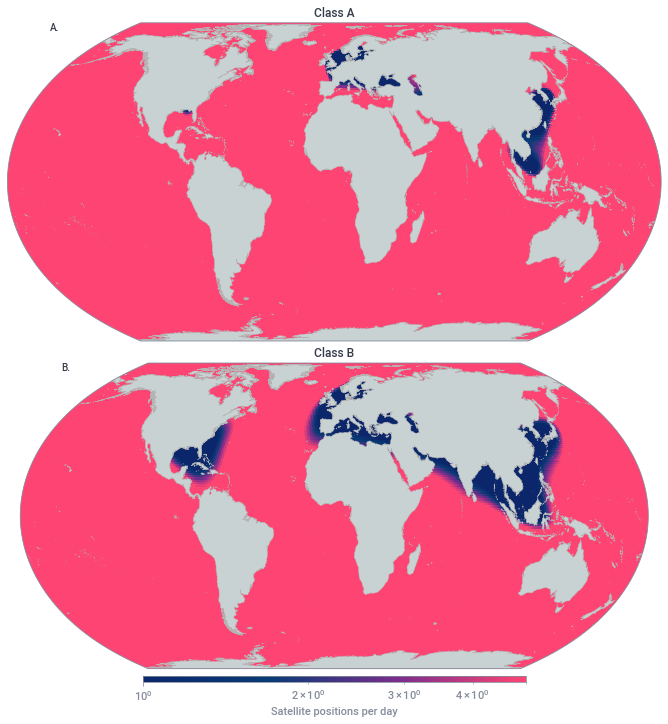

In [87]:
# Plot reception quality with same color scales
utils.plot_reception_quality(reception_start_date = start_date,
                             reception_df = sat_reception_smooth,
                             fig_min_value = 1,
                             fig_max_value = 5
                        )

### Residuals

Remake residual plot with different color scales for class A and B. 

First, pull out the measured reception quality to compare against the smoothed reception quality.

In [38]:
%%bigquery sat_residuals
WITH

smooth AS (
  SELECT 
  lat_bin,
  lon_bin,
  class,
  AVG(positions_per_day) as positions_per_day
  FROM proj_ais_gaps_catena.sat_reception_smoothed_one_degree_v20210722
  WHERE _partitiontime BETWEEN "2017-01-01" AND "2019-12-01"
  GROUP BY 1,2,3
),

measured AS (
  SELECT 
  lat_bin,
  lon_bin,
  cls as class,
  AVG(sat_pos_per_day) as positions_per_day_measured,
  SUM(hours) as hours
  FROM proj_ais_gaps_catena.sat_reception_measured_one_degree_v20210722
  WHERE _partitiontime BETWEEN "2017-01-01" AND "2019-12-01"
  GROUP BY 1,2,3
)

SELECT
*,
positions_per_day_measured - positions_per_day as residual,
positions_per_day_measured_cap - positions_per_day_cap as residual_cap
FROM (
  SELECT 
  *,
  IF(positions_per_day_measured > 100, 100, positions_per_day_measured) as positions_per_day_measured_cap,
  IF(positions_per_day > 100, 100, positions_per_day) as positions_per_day_cap
  FROM measured
  LEFT JOIN smooth
  USING (lat_bin, lon_bin, class)
)
WHERE hours > 24

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 59556/59556 [00:01<00:00, 37731.47rows/s]


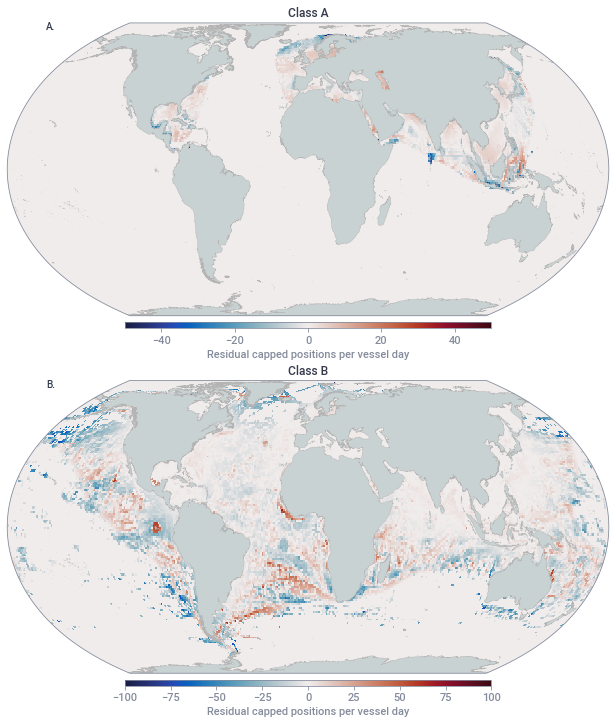

In [39]:
# Remove NA coordinate rows
sat_residuals = sat_residuals.dropna(subset=['lat_bin','lon_bin'])

# Pull out class A and B capped residuals
class_a_cap_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','residual_cap',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_cap_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','residual_cap',
                                                  xyscale=1, 
                                                  per_km2=False)

# Plot
fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light): 

    axes = []
    ims = []
    fig_a_min_value = -50
    fig_a_max_value = 50  

    # Class A
    grid = class_a_cap_residuals
    norm = colors.Normalize(vmin=fig_a_min_value, vmax=fig_a_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Residual capped positions per vessel day")
    
    # Class B
    fig_b_min_value = -100
    fig_b_max_value = 100
    
    grid = class_b_cap_residuals
    norm = colors.Normalize(vmin=fig_b_min_value, vmax=fig_b_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Residual capped positions per vessel day")

    plt.tight_layout(pad=0.5)
plt.savefig("../results/gap_figures_{}/figure_si_reception_residuals.png".format(output_version),dpi=200, bbox_inches='tight') 

### Residual histograms

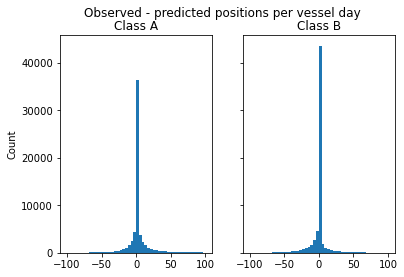

In [36]:
# Pull out class A and B capped residuals
class_a_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','residual',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_residuals = pyseas.maps.rasters.df2raster(sat_residuals[sat_residuals['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','residual',
                                                  xyscale=1, 
                                                  per_km2=False)

# set axes range
ax_range = 100
bins = 50

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=False)
fig.suptitle('Observed - predicted positions per vessel day')

ax1.hist(class_a_residuals.flatten(), range=(-ax_range, ax_range), bins=bins)
ax1.title.set_text('Class A')
ax1.set(ylabel = 'Count')

ax2.hist(class_b_residuals.flatten(), range=(-ax_range, ax_range), bins=bins)
ax2.title.set_text('Class B')

# Save figure
plt.savefig('../results/gap_figures_{}/figure_si_residual_distribution.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])

## Gap length

Get the lenght of all AIS gaps, with suspected disabling events labeled.

In [41]:
%%bigquery gap_length
SELECT 
  ssvid,
  vessel_class,
  off_class,
  gap_hours,
  gap_distance_m / 1000 as gap_distance_km,
  IF (
   positions_X_hours_before_sat >= 19 
   AND (positions_per_day_off > 5 AND positions_per_day_on > 5), True,  False
  ) as likely_disabling
FROM `world-fishing-827.proj_ais_gaps_catena.ais_gap_events_features_v20210722` 
WHERE gap_hours >= 12
AND (off_distance_from_shore_m > 1852*50 AND on_distance_from_shore_m > 1852*50)
AND (DATE(gap_start) >= '2017-01-01' AND DATE(gap_end) <= '2019-12-31')

Downloading: 100%|██████████████████████████████████████████████████████████████████| 407421/407421 [00:01<00:00, 206834.21rows/s]


In [42]:
gap_length

,ssvid,vessel_class,off_class,gap_hours,gap_distance_km,likely_disabling
0,412440434,purse_seines,B,17.283333,18.813744,False
1,503667400,pots_and_traps,B,12.133333,4.877416,True
2,412440483,purse_seines,B,108.350000,11.542955,False
3,316021795,pots_and_traps,B,12.533333,3.460402,False
4,412365286,other_purse_seines,B,153.866667,89.072461,False
...,...,...,...,...,...,...
407416,431700454,drifting_longlines,B,22.700000,61.830526,False
407417,416002847,drifting_longlines,B,12.183333,32.419031,False
407418,416002231,drifting_longlines,B,13.416667,13.068638,False
407419,416003306,drifting_longlines,B,12.150000,20.778551,False


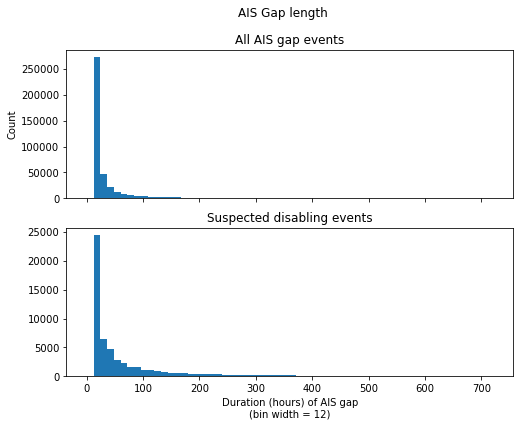

In [85]:
# set axes range
ax_range = 24*30
bins = 60

fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, sharex=True, figsize = (8,6))
fig.suptitle('AIS Gap length')

ax1.hist(gap_length['gap_hours'], 
         range=(0, ax_range),
         bins=bins)

ax1.title.set_text('All AIS gap events')
ax1.set(ylabel = 'Count')

ax2.hist(gap_length.loc[gap_length['likely_disabling'] == True, 'gap_hours'], 
         range=(0, ax_range),
         bins=bins)

ax2.title.set_text('Suspected disabling events')
ax2.set(xlabel = 'Duration (hours) of AIS gap\n(bin width = 12)')

plt.savefig('../results/gap_figures_{}/figure_si_gap_hours_hist.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])

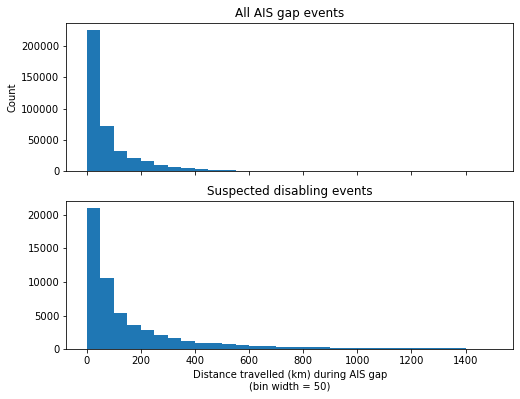

In [86]:
# set axes range
ax_range = 1500
bins = 30

fig, (ax1, ax2) = plt.subplots(2,1, sharey=False, sharex=True, figsize=(8,6))

ax1.hist(gap_length['gap_distance_km'], 
         range=(0, ax_range),
         bins=bins)

ax1.title.set_text('All AIS gap events')
ax1.set(ylabel = 'Count')

ax2.hist(gap_length.loc[gap_length['likely_disabling'] == True, 'gap_distance_km'], 
         range=(0, ax_range),
         bins=bins)

ax2.title.set_text('Suspected disabling events')
ax2.set(xlabel = 'Distance travelled (km) during AIS gap\n(bin width = 50)')

plt.savefig('../results/gap_figures_{}/figure_si_gap_distance_hist.png'.format(output_version), dpi=200, facecolor=plt.rcParams['pyseas.fig.background'])

# Alternate Reception Quality Maps

Our reception quality maps are based on a series of assumptions pertaining to vessel class and speed. They also are based on data that includes intentional AIS disabling events. The following analyses test the robustness of these assumptions.

## No speed restriction

Our reception quality maps are based on AIS positions when vessels travel between 0.5-14 knots for Class A and >2 knots for Class B. 

>  and (-- if Class A, moving at the speed to ping once every 10 seconds
   (by_half_day.A_messages > 0 and  min_interpolated_speed_knots > 0.5
    and max_interpolated_speed_knots < 14)
   or (by_half_day.B_messages > 0 and min_interpolated_speed_knots > 2 ))

This is due to the fact that AIS devices ping a faster/slower rates depending on speed and we want to avoid biasing reception quality estimates.

In [77]:
# Reception quality tables
sat_reception_smoothed_all_speeds_tbl = 'sat_reception_smoothed_one_degree_all_speeds_{}'.format(output_version)

First, identify suspected disabling events using a 5 positions per day threshold from the two different reception quality methods.

In [78]:
%%bigquery total_gaps_reception_types
CREATE TEMP FUNCTION start_date() AS (DATE('2017-01-01'));
CREATE TEMP FUNCTION end_date() AS (DATE('2019-12-31'));
--
WITH
  #
  # Current gaps table
  #
  gaps AS (
      SELECT
      *,
      EXTRACT(month from gap_start) as month,
      floor(off_lat) as off_lat_bin, # lat bin for joining with reception
      floor(off_lon) as off_lon_bin, # lon bin for joining with reception
      floor(on_lat) as on_lat_bin, # lat bin for joining with reception
      floor(on_lon) as on_lon_bin # lon bin for joining with reception
      FROM `world-fishing-827.proj_ais_gaps_catena.ais_gap_events_features_v20210722`
      WHERE year < 2020
  ),
  #
  # Alternate reception quality (no speed restrictions)
  #
  reception_all_speeds AS (
      SELECT * EXCEPT(positions_per_day),
      IF(positions_per_day < 0, 0, positions_per_day) as positions_per_day_all_speeds
      FROM `world-fishing-827.proj_ais_gaps_catena.sat_reception_smoothed_one_degree_all_speeds_v20210722`
  ),
#
# Reception at the lat/lon where the gap starts
#
off_quality AS (
SELECT
  gap_id,
  gap_start,
  gap_end,
  a.positions_per_day_all_speeds AS positions_per_day_off_all_speeds
FROM
  reception_all_speeds a
JOIN
  gaps b
ON
  a.lat_bin = b.off_lat_bin
  AND a.lon_bin = b.off_lon_bin
  AND a.year = b.year
  AND a.month = b.month
  AND a.class = b.off_class),
--
# Reception at the lat/lon where the gap ends
on_quality AS (
SELECT
  gap_id,
  gap_start,
  gap_end,
  a.positions_per_day_all_speeds AS positions_per_day_on_all_speeds
FROM
  reception_all_speeds as a
JOIN
  gaps b
ON
  a.lat_bin = b.on_lat_bin
  AND a.lon_bin = b.on_lon_bin
  AND a.year = b.year
  AND a.month = b.month
  AND a.class = b.on_class),
--
# Join gaps with off reception
gaps_reception AS(
SELECT
  *
  # Exclude reception related variables
  EXCEPT(off_lat_bin, off_lon_bin, on_lat_bin, on_lon_bin)
FROM gaps
LEFT JOIN off_quality
USING(gap_id, gap_start, gap_end)
LEFT JOIN on_quality
USING(gap_id, gap_start, gap_end)
),
# 
# Calculate disabling events with both reception quality thresholds
#
  disabling AS (
      SELECT
      *,
      IF(positions_per_day_off > 5 AND positions_per_day_on > 5, 1, 0) disabling_event,
      IF(positions_per_day_off_all_speeds > 5 AND positions_per_day_on_all_speeds > 5, 1, 0) disabling_event_all_speeds,
      FROM gaps_reception
      WHERE gap_hours >= 12
      AND (off_distance_from_shore_m > 1852*50 AND on_distance_from_shore_m > 1852*50)
      AND (DATE(gap_start) >= start_date() AND DATE(gap_end) <= end_date())
      AND positions_X_hours_before_sat >= 19
  )
#
# Summarize disabling events by reception quality type
#
SELECT 
SUM(disabling_event) as disabling_events,
SUM(disabling_event_all_speeds) as disabling_events_all_speeds
FROM disabling

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/rows]


In [79]:
total_gaps_reception_types.head()

,disabling_events,disabling_events_all_speeds
0,56802,56367


There are 435 (0.7%) fewer suspected disabling events when using a reception quality map based on all speeds and the 5 positions per day threshold.  
  
Query the two versions of reception quality and return the difference in positions used to calculate reception quality, average measured reception quality, and average smoothed reception quality.

In [82]:
%%bigquery reception_all_speeds
WITH 
-- Join reception quality
reception_measured_joined AS (
    SELECT 
    a.lat_bin,
    a.lon_bin,
    a.cls as class,
    a.hours,
    a.sat_pos_per_day,
    b.sat_pos_per_day as sat_pos_per_day_all_speeds,
    b.hours as hours_all_speeds
    FROM `world-fishing-827.proj_ais_gaps_catena.sat_reception_measured_one_degree_v20210722` a
    FULL JOIN `world-fishing-827.proj_ais_gaps_catena.sat_reception_measured_one_degree_all_speeds_v20210722` b
    USING(lat_bin, lon_bin, cls, _partitiontime)
),
-- Get smoothed reception quality 
reception_smoothed_joined AS (
    SELECT 
    a.lat_bin,
    a.lon_bin,
    a.class,
    a.positions_per_day,
    b.positions_per_day as positions_per_day_all_speeds,
    FROM `world-fishing-827.proj_ais_gaps_catena.sat_reception_smoothed_one_degree_v20210722` a
    FULL JOIN `world-fishing-827.proj_ais_gaps_catena.sat_reception_smoothed_one_degree_all_speeds_v20210722` b
    USING(lat_bin, lon_bin, class, _partitiontime)
),
--
-- Join measured and smooth reception
reception_joined AS(
    SELECT *
    FROM reception_smoothed_joined 
    LEFT JOIN reception_measured_joined 
    USING(lat_bin, lon_bin, class)
)
-- Calculate difference and percent difference in hours (proxy for positions) and reception
SELECT 
  *,
  sat_pos_per_day - sat_pos_per_day_all_speeds as sat_pos_per_day_diff,
  SAFE_DIVIDE((sat_pos_per_day - sat_pos_per_day_all_speeds ), sat_pos_per_day) * 100 as sat_pos_per_day_perc,
  positions_per_day - positions_per_day_all_speeds as sat_pos_per_day_smooth_diff,
  SAFE_DIVIDE((positions_per_day - positions_per_day_all_speeds), positions_per_day) * 100 as sat_pos_per_day_smooth_perc,
  positions_per_day_cap - positions_per_day_all_speeds_cap as sat_pos_per_day_smooth_cap_diff,
  SAFE_DIVIDE((positions_per_day_cap - positions_per_day_all_speeds_cap), positions_per_day_cap) * 100 as sat_pos_per_day_smooth_cap_perc,
  hours - hours_all_speeds as hours_diff,
  SAFE_DIVIDE((hours - hours_all_speeds), hours) * 100 as hours_perc
FROM(
  SELECT 
  *,
  IF(positions_per_day > 5, 5, positions_per_day) as positions_per_day_cap,
  IF(positions_per_day_all_speeds > 5, 5, positions_per_day_all_speeds) as positions_per_day_all_speeds_cap
  FROM (
      SELECT 
      lat_bin,
      lon_bin,
      class,
      SUM(hours) as hours,
      SUM(hours_all_speeds) as hours_all_speeds,
      AVG(sat_pos_per_day) as sat_pos_per_day,
      AVG(sat_pos_per_day_all_speeds) as sat_pos_per_day_all_speeds,
      AVG(positions_per_day) as positions_per_day,
      AVG(positions_per_day_all_speeds) positions_per_day_all_speeds 
      FROM reception_joined 
      GROUP BY lat_bin, lon_bin, class
  )
)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129600/129600 [00:06<00:00, 21277.35rows/s]


Plot the residuals between the two modeled reception quality versions, capping the predicted vessel positions per day at 5 to highlight the areas where the two approaches would change results.

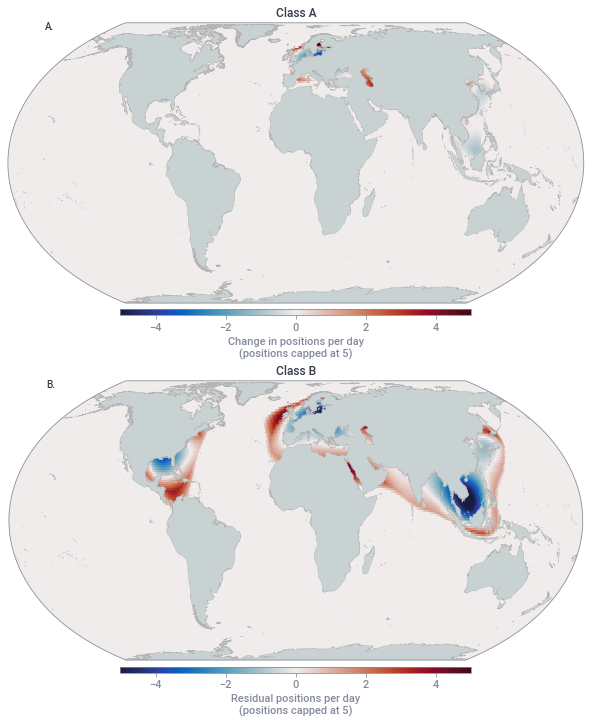

In [83]:
# Remove NA coordinate rows
reception_all_speeds_tmp = reception_all_speeds.dropna(subset=['lat_bin','lon_bin'])

# Pull out class A and B changes from all speeds
class_a_diff = pyseas.maps.rasters.df2raster(reception_all_speeds_tmp[reception_all_speeds_tmp['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','sat_pos_per_day_smooth_cap_diff',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_diff = pyseas.maps.rasters.df2raster(reception_all_speeds_tmp[reception_all_speeds_tmp['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','sat_pos_per_day_smooth_cap_diff',
                                                  xyscale=1, 
                                                  per_km2=False)

# Plot
fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light): 

    axes = []
    ims = []
    fig_a_min_value = -5
    fig_a_max_value = 5  

    # Class A
    grid = class_a_diff
    norm = colors.Normalize(vmin=fig_a_min_value, vmax=fig_a_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Change in positions per day\n(positions capped at 5)")
    
    # Class B
    fig_b_min_value = -5
    fig_b_max_value = 5
    
    grid = class_b_diff
    norm = colors.Normalize(vmin=fig_b_min_value, vmax=fig_b_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Residual positions per day\n(positions capped at 5)")

    plt.tight_layout(pad=0.5)

Now plot the difference in the number of hours used to calculate the measured reception quality for both versions. This should show where the speed restrictions are affecting the positions included in the reception quality calculation.

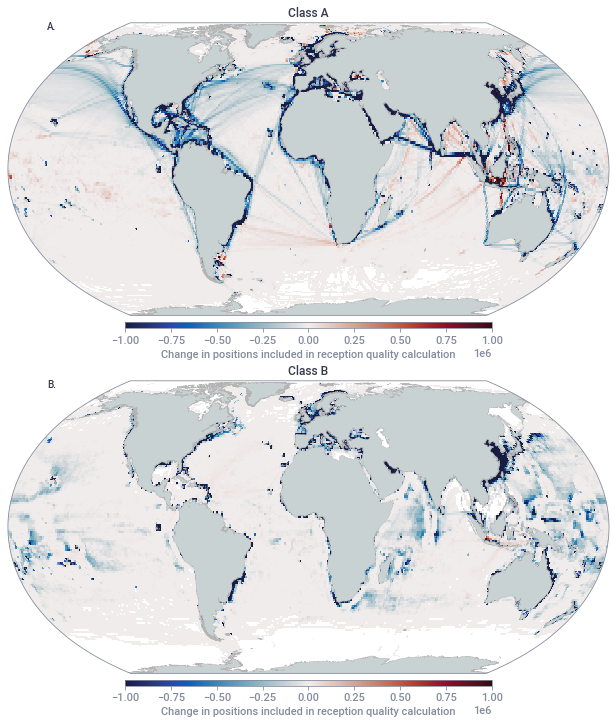

In [69]:
# Remove NA coordinate rows
reception_all_speeds_tmp = reception_all_speeds.dropna(subset=['lat_bin','lon_bin'])

# Pull out class A and B changes from all speeds
class_a_diff = pyseas.maps.rasters.df2raster(reception_all_speeds_tmp[reception_all_speeds_tmp['class'] == 'A'], 
                                                  'lon_bin', 'lat_bin','hours_diff',
                                                  xyscale=1, 
                                                  per_km2=False)

class_b_diff = pyseas.maps.rasters.df2raster(reception_all_speeds_tmp[reception_all_speeds_tmp['class'] == 'B'], 
                                                  'lon_bin', 'lat_bin','hours_diff',
                                                  xyscale=1, 
                                                  per_km2=False)

# Plot
fig = plt.figure(figsize=(10,10))

titles = ["Class A",
          "Class B"]

with pyseas.context(pyseas.styles.light): 

    axes = []
    ims = []
    fig_a_min_value = -1e6
    fig_a_max_value = 1e6  

    # Class A
    grid = class_a_diff
    norm = colors.Normalize(vmin=fig_a_min_value, vmax=fig_a_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,1),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class A")
    ax.text(-150*1000*100,80*1000*100, "A.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Change in hours included in reception quality calculation")
    
    # Class B
    fig_b_min_value = -1e6
    fig_b_max_value = 1e6
    
    grid = class_b_diff
    norm = colors.Normalize(vmin=fig_b_min_value, vmax=fig_b_max_value)

    ax, im = pyseas.maps.plot_raster(grid,
                                     subplot=(2,1,2),
                                     cmap = cmocean.cm.balance,
                                     origin = 'upper',
                                     norm = norm
                                    )

    ax.set_title("Class B")
    ax.text(-150*1000*100,80*1000*100, "B.")

    cbar = fig.colorbar(im, ax=ax,
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=60,
                      pad=0.02,
                     )

    cbar.set_label(f"Change in hours included in reception quality calculation")

    plt.tight_layout(pad=0.5)

In [43]:
"""
Query smoothed reception data
"""
sat_reception_smooth_all_speeds_query = '''SELECT 
                                   lat_bin,
                                   lon_bin,
                                   class,
                                   AVG(positions_per_day) as positions_per_day
                                   FROM `{d}.{t}`
                                   WHERE _partitiontime BETWEEN "2017-01-01" 
                                   AND "2019-12-01"
                                   GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                            t = sat_reception_smoothed_all_speeds_tbl)
# Query data
sat_reception_smooth_all_speeds = pd.read_gbq(sat_reception_smooth_all_speeds_query, project_id='world-fishing-827', dialect='standard')

/opt/miniconda3/envs/rad/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


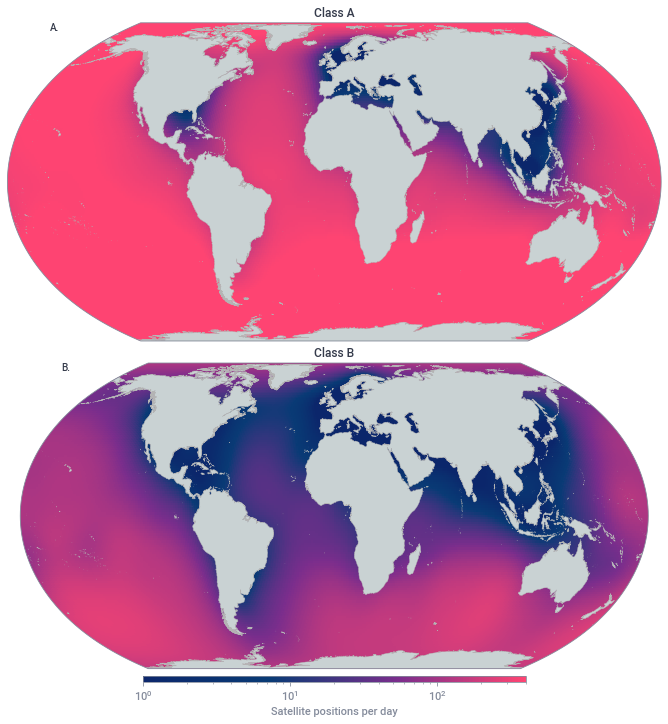

In [51]:
# Plot reception quality with same color scales
utils.plot_reception_quality(reception_start_date = start_date,
                             reception_df = sat_reception_smooth_all_speeds
                        )

Cells that change from 5 positions per day